In [2]:
# 1. Imports, load and preprocess data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
import zipfile
import optuna
import os

def load_data():
    fd001_path = "FD001"

    col_names = ['unit', 'cycle'] + [f'op_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
    train = pd.read_csv(os.path.join(fd001_path, 'train_FD001.txt'), sep='\s+', header=None, names=col_names)
    train.columns = col_names
    
    test = pd.read_csv(os.path.join(fd001_path, 'test_FD001.txt'), sep='\s+', header=None, names=col_names)
    test.columns = col_names

    rul = pd.read_csv(os.path.join(fd001_path, 'RUL_FD001.txt'), header=None, names=['RUL'])
    rul = rul.dropna().astype(int).reset_index(drop=True)
    
    return train, test, rul

train_df, test_df, rul_df = load_data()

# Add RUL to train
train_df['max_cycle'] = train_df.groupby('unit')['cycle'].transform('max')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

# Add RUL to test
rul_df['unit'] = rul_df.index + 1
max_cycles = test_df.groupby('unit')['cycle'].max().reset_index()
rul_merged = max_cycles.merge(rul_df, on='unit')
rul_merged['final_RUL'] = rul_merged['RUL'] + rul_merged['cycle']
test_df = test_df.merge(rul_merged[['unit', 'final_RUL']], on='unit')
test_df['RUL'] = test_df['final_RUL'] - test_df['cycle']
test_df.drop(columns=['final_RUL'], inplace=True)

# Feature selection and scaling
feature_cols = [col for col in train_df.columns if 'sensor' in col or 'op_' in col]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = train_df['RUL'].values
y_test = test_df['RUL'].values

In [3]:
# 2. Random Forest with All Features
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest (All Features) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest (All Features) MAE:", mean_absolute_error(y_test, y_pred_rf))

Random Forest (All Features) RMSE: 46.32193753980901
Random Forest (All Features) MAE: 35.00478390348198


In [34]:
r2 = r2_score(y_test, y_pred_rf)
r2

0.38312754194894827

In [33]:
# 3. Random Forest with PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestRegressor(random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_test_pca)

print("Random Forest (PCA) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf_pca)))
print("Random Forest (PCA) MAE:", mean_absolute_error(y_test, y_pred_rf_pca))
r2 = r2_score(y_test, y_pred_rf_pca)
r2

Random Forest (PCA) RMSE: 47.641176414497785
Random Forest (PCA) MAE: 35.960744502138056


0.3474904064362021

In [ ]:
# 4. Random Forest with PCA and Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_pca, y_train)

print("Best RF Params:", grid_search.best_params_)
y_pred_rf_tuned = grid_search.predict(X_test_pca)
print("Random Forest (Tuned + PCA) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf_tuned)))
print("Random Forest (Tuned + PCA) MAE:", mean_absolute_error(y_test, y_pred_rf_tuned))

Best RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest (Tuned + PCA) RMSE: 46.549752462360836
Random Forest (Tuned + PCA) MAE: 34.972707535264945


In [35]:
r2 = r2_score(y_test, y_pred_rf_tuned)
r2

0.3770449670704006

In [6]:
# 5. Dataset class
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X_seq, self.y_seq = [], []
        for i in range(len(X) - seq_len):
            self.X_seq.append(X[i:i+seq_len])
            self.y_seq.append(y[i+seq_len])
        self.X_seq = np.array(self.X_seq, dtype=np.float32)
        self.y_seq = np.array(self.y_seq, dtype=np.float32)

    def __len__(self): return len(self.X_seq)
    def __getitem__(self, idx): return self.X_seq[idx].squeeze(), self.y_seq[idx]

In [7]:
# 6. Model definitions
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1]).squeeze()

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.attn_fc = nn.Linear(hidden_dim, 1)
        self.out = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = F.softmax(self.attn_fc(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        return self.out(context).squeeze()

In [8]:
# 7. Optuna tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial, model_type, X_train, y_train):
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model_cls = GRUModel if model_type == 'GRU' else AttentionLSTM
    model = model_cls(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(5):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    val_preds, val_trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            preds = model(xb).cpu().numpy()
            val_preds.extend(preds)
            val_trues.extend(yb.numpy())
    mae = mean_absolute_error(val_trues, val_preds)
    return mae

In [9]:
# 8. Run optimization (WARNING: may take ~30 minutes to run)
X_seq_len = 30
for model_type in ['GRU', 'Attention']:
    study = optuna.create_study(direction="minimize")
    
    def create_sequence_data(X_raw, y_raw, seq_len):
        X_seq, y_seq = [], []
        for i in range(len(X_raw) - seq_len):
            X_seq.append(X_raw[i:i+seq_len])
            y_seq.append(y_raw[i+seq_len])
        return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

    X_seq_pca, y_seq_pca = create_sequence_data(X_train_pca, y_train, seq_len=X_seq_len)

    study.optimize(lambda trial: objective(trial, model_type, X_seq_pca, y_seq_pca), n_trials=20)

    print(f"Best {model_type} config:")
    print(study.best_params)

[I 2025-07-11 17:27:18,349] A new study created in memory with name: no-name-d2e1e3d1-bf47-4685-ad7d-e70500069fba
[I 2025-07-11 17:28:59,320] Trial 0 finished with value: 28.681721577001575 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.015057744230053127, 'lr': 0.002791856840934276}. Best is trial 0 with value: 28.681721577001575.
c:\Users\diane\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28828210298822676 and num_layers=1
  warnings.warn(
[I 2025-07-11 17:29:44,302] Trial 1 finished with value: 34.56810830159185 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.28828210298822676, 'lr': 0.0005789611310079483}. Best is trial 0 with value: 28.681721577001575.
[I 2025-07-11 17:32:29,518] Trial 2 finished with value: 56.82187867793034 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropou

Best GRU config:
{'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.11363447881932812, 'lr': 0.002993102907927516}


[I 2025-07-11 17:48:33,418] Trial 0 finished with value: 98.59641813284031 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.37834733241804425, 'lr': 0.00010533585233209632}. Best is trial 0 with value: 98.59641813284031.
c:\Users\diane\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.47010042661427165 and num_layers=1
  warnings.warn(
[I 2025-07-11 17:48:38,661] Trial 1 finished with value: 91.16759852864003 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.47010042661427165, 'lr': 0.000263057281655747}. Best is trial 1 with value: 91.16759852864003.
c:\Users\diane\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10834207516807604 and num_layers

Best Attention config:
{'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.0064088108022656, 'lr': 0.009497852960682717}


In [36]:
# 9. Create final sequence datasets for full training and test evaluation
X_seq_pca, y_seq_pca = create_sequence_data(X_train_pca, y_train, seq_len=X_seq_len)
X_seq_test, y_seq_test = create_sequence_data(X_test_pca, test_df['RUL'].values, seq_len=X_seq_len)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_seq_pca, dtype=torch.float32),
    torch.tensor(y_seq_pca, dtype=torch.float32))

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_seq_test, dtype=torch.float32),
    torch.tensor(y_seq_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [37]:
# 10. Final Training and Evaluation for Best Models (may take 10-15 minutes to run)
final_results = {}

for model_type in ['GRU', 'Attention']:
    print(f"\n--- Training Final {model_type} Model ---")
    best_params = study.best_params

    model_cls = GRUModel if model_type == 'GRU' else AttentionLSTM
    model = model_cls(
        input_dim=X_seq_pca.shape[2],
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
    loss_fn = nn.MSELoss()
    train_losses = []

    for epoch in range(20):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # Evaluation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            out = model(xb).cpu().numpy()
            preds.extend(out)
            trues.extend(yb.numpy())

    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)

    final_results[model_type] = {
        'model': model,
        'train_losses': train_losses,
        'preds': preds,
        'trues': trues,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    }


--- Training Final GRU Model ---
Epoch 1: Loss = 6975.6545
Epoch 2: Loss = 2550.9619
Epoch 3: Loss = 1456.6676
Epoch 4: Loss = 1186.2809
Epoch 5: Loss = 923.4241
Epoch 6: Loss = 703.5930
Epoch 7: Loss = 557.8775
Epoch 8: Loss = 459.3992
Epoch 9: Loss = 572.9596
Epoch 10: Loss = 482.6102
Epoch 11: Loss = 432.3299
Epoch 12: Loss = 357.6722
Epoch 13: Loss = 321.3910
Epoch 14: Loss = 312.1832
Epoch 15: Loss = 327.8527
Epoch 16: Loss = 465.3640
Epoch 17: Loss = 403.1373
Epoch 18: Loss = 347.8632
Epoch 19: Loss = 334.8575
Epoch 20: Loss = 306.7667

--- Training Final Attention Model ---
Epoch 1: Loss = 7083.4273
Epoch 2: Loss = 2876.1387
Epoch 3: Loss = 1681.5149
Epoch 4: Loss = 1391.5356
Epoch 5: Loss = 1230.5797
Epoch 6: Loss = 872.4656
Epoch 7: Loss = 638.4054
Epoch 8: Loss = 437.0285
Epoch 9: Loss = 354.8484
Epoch 10: Loss = 297.7384
Epoch 11: Loss = 266.9756
Epoch 12: Loss = 270.4179
Epoch 13: Loss = 239.6156
Epoch 14: Loss = 230.9266
Epoch 15: Loss = 251.8783
Epoch 16: Loss = 267.3468

In [28]:
import pandas as pd

# Extract evaluation metrics from final_results
metrics_summary = []
for model_name, result in final_results.items():
    metrics = result['metrics']
    metrics_summary.append({
        "Model": model_name,
        "RMSE": metrics['RMSE'],
        "MAE": metrics['MAE'],
        "R²": metrics['R2']
    })

# Create and display a DataFrame
metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.set_index("Model")
display(metrics_df)


,RMSE,MAE,R²
Model,,,
GRU,50.762548,38.474414,0.260755
Attention,54.732702,40.964622,0.140600


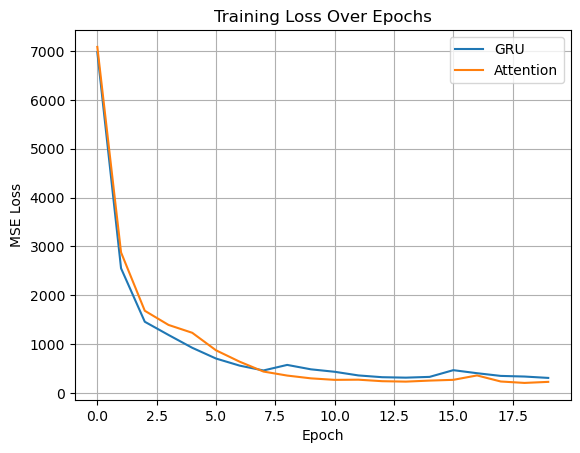

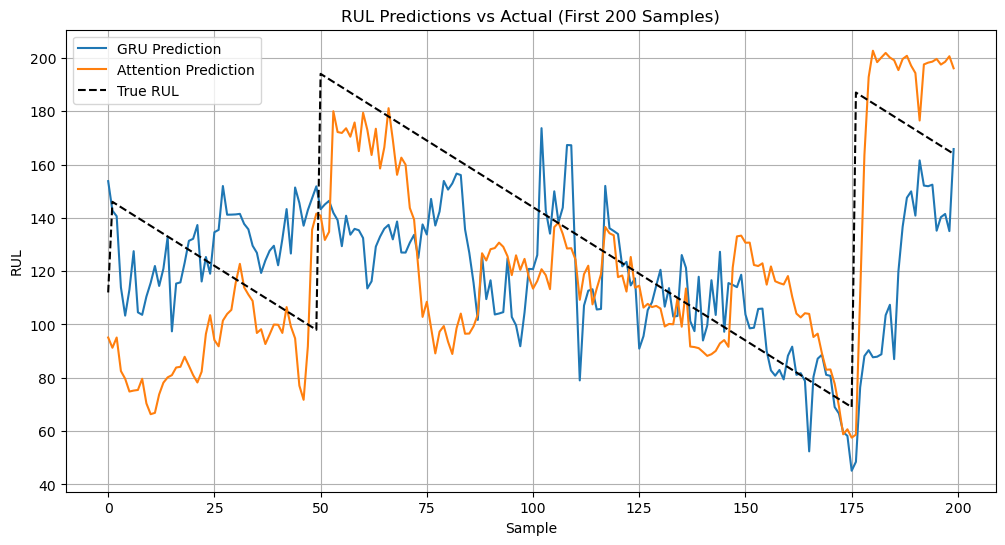

In [38]:
# 11. Visualize Training and Results
for name, res in final_results.items():
    plt.plot(res['train_losses'], label=name)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for name, res in final_results.items():
    plt.plot(res['preds'][:200], label=f"{name} Prediction")
plt.plot(res['trues'][:200], label="True RUL", linestyle='--', color='black')
plt.title("RUL Predictions vs Actual (First 200 Samples)")
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

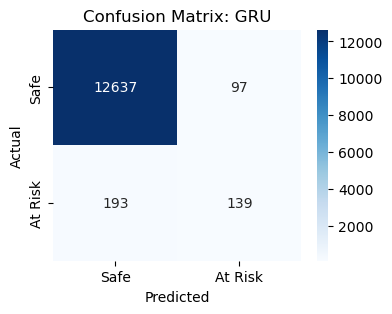

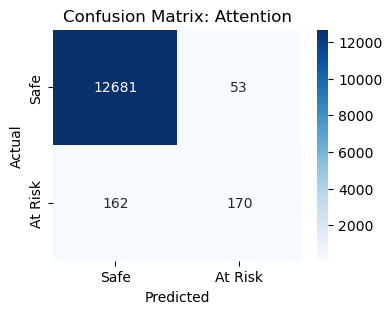

,RMSE,MAE,R^2,Cls_Acc,Cls_F1,Cls_Precision,Cls_Recall
GRU,50.763,38.474,0.261,0.978,0.489,0.589,0.419
Attention,54.733,40.965,0.141,0.984,0.613,0.762,0.512


In [30]:
# 12. Print Metric Summary
full_metrics = {}

def classify_rul(preds, trues, threshold=30):
    y_pred_bin = (np.array(preds) <= threshold).astype(int)
    y_true_bin = (np.array(trues) <= threshold).astype(int)
    return y_pred_bin, y_true_bin

for model_name, res in final_results.items():
    preds = res['preds']
    trues = res['trues']

    # Regression
    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)

    # Classification via threshold
    y_pred_bin, y_true_bin = classify_rul(preds, trues)
    acc = accuracy_score(y_true_bin, y_pred_bin)
    f1 = f1_score(y_true_bin, y_pred_bin)
    prec = precision_score(y_true_bin, y_pred_bin)
    rec = recall_score(y_true_bin, y_pred_bin)

    cm = confusion_matrix(y_true_bin, y_pred_bin)

    # Confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'At Risk'], yticklabels=['Safe', 'At Risk'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()
    
    full_metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Cls_Acc': acc,
        'Cls_F1': f1,
        'Cls_Precision': prec,
        'Cls_Recall': rec
    }

# Display full metric comparison
metrics_df = pd.DataFrame(full_metrics).T.round(3)
display(metrics_df)

In [14]:
# 13. Classification Evaluation from RUL Predictions
print("\nClassification Metrics from Thresholding (RUL ≤ 30):")
for name, res in final_results.items():
    true_bin = (np.array(res['trues']) <= 30).astype(int)
    pred_bin = (np.array(res['preds']) <= 30).astype(int)
    rmse = np.sqrt(mean_squared_error(true_bin, pred_bin))
    mae = mean_absolute_error(true_bin, pred_bin)
    acc = accuracy_score(true_bin, pred_bin)
    f1 = f1_score(true_bin, pred_bin)
    prec = precision_score(true_bin, pred_bin)
    rec = recall_score(true_bin, pred_bin)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, Acc: {acc:.2f}, F1: {f1:.2f}, Prec: {prec:.2f}, Recall: {rec:.2f}")


Classification Metrics from Thresholding (RUL ≤ 30):
GRU → RMSE: 0.15, MAE: 0.02, Acc: 0.98, F1: 0.43, Prec: 0.61, Recall: 0.33
Attention → RMSE: 0.12, MAE: 0.01, Acc: 0.99, F1: 0.69, Prec: 0.75, Recall: 0.64


In [15]:
print("Random Forest (All Features) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest (All Features) MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest (All Features) R^2:", r2_score(y_test, y_pred_rf))

print("Random Forest (PCA) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf_pca)))
print("Random Forest (PCA) MAE:", mean_absolute_error(y_test, y_pred_rf_pca))
print("Random Forest (PCA) R^2:", r2_score(y_test, y_pred_rf_pca))

print("Random Forest (Tuned + PCA) RMSE:", sqrt(mean_squared_error(y_test, y_pred_rf_tuned)))
print("Random Forest (Tuned + PCA) MAE:", mean_absolute_error(y_test, y_pred_rf_tuned))
print("Random Forest (Tuned + PCA) R^2:", r2_score(y_test, y_pred_rf_tuned))

Random Forest (All Features) RMSE: 46.32193753980901
Random Forest (All Features) MAE: 35.00478390348198
Random Forest (All Features) R^2: 0.38312754194894827
Random Forest (PCA) RMSE: 47.641176414497785
Random Forest (PCA) MAE: 35.960744502138056
Random Forest (PCA) R^2: 0.3474904064362021
Random Forest (Tuned + PCA) RMSE: 46.549752462360836
Random Forest (Tuned + PCA) MAE: 34.972707535264945
Random Forest (Tuned + PCA) R^2: 0.3770449670704006


In [16]:
# # 14. Random Forest Classifier (Baseline)

# # Create classification labels for training set (based on RUL <= 30)
# y_train_class = (y_train <= 30).astype(int)

# # Train Random Forest on last sequence per unit (simple baseline)
# X_rf_train = []
# y_rf_train = []
# last_units = train_df.groupby('unit').tail(1)
# X_rf_raw = scaler.transform(last_units[feature_cols])

# X_rf_train = X_rf_raw
# y_rf_train = (last_units['RUL'] <= 30).astype(int)

# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_rf_train, y_rf_train)

# # Test on final point per test unit
# test_last = test_df.groupby('unit').tail(1)
# X_rf_test = scaler.transform(test_last[feature_cols])
# y_rf_test = (test_last['RUL'] <= 30).astype(int)
# rf_preds = rf.predict(X_rf_test)

# acc_rf = accuracy_score(y_rf_test, rf_preds)
# f1_rf = f1_score(y_rf_test, rf_preds)
# prec_rf = precision_score(y_rf_test, rf_preds)
# rec_rf = recall_score(y_rf_test, rf_preds)

# print("\nRandom Forest Classifier on Final Cycle per Unit:")
# print(f"Acc: {acc_rf:.2f}, F1: {f1_rf:.2f}, Prec: {prec_rf:.2f}, Recall: {rec_rf:.2f}")

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluation function
def evaluate_rul_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("Model Evaluation Metrics:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.2f}")
    
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# Apply to your data
evaluate_rul_predictions(y_test, y_pred_rf)
evaluate_rul_predictions(y_test, y_pred_rf_pca)
evaluate_rul_predictions(y_test, y_pred_rf_tuned)


Model Evaluation Metrics:
  RMSE: 46.32
  MAE:  35.00
  R²:   0.38
Model Evaluation Metrics:
  RMSE: 47.64
  MAE:  35.96
  R²:   0.35
Model Evaluation Metrics:
  RMSE: 46.55
  MAE:  34.97
  R²:   0.38


{'RMSE': 46.549752462360836,
 'MAE': 34.972707535264945,
 'R2': 0.3770449670704006}